In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

In [ ]:
# Loading IMDb India Movies dataset from Kaggle
df = pd.read_csv('IMDb Movies India.csv', encoding='latin1')

print("Shape:", df.shape)
print("Columns:", df.columns.tolist())

Shape: (15509, 10)
Columns: ['Name', 'Year', 'Duration', 'Genre', 'Rating', 'Votes', 'Director', 'Actor 1', 'Actor 2', 'Actor 3']


In [11]:
# Safe cleaning for ALL columns
df['Year'] = pd.to_numeric(df['Year'].astype(str), errors='coerce').fillna(2000)
df['Votes'] = pd.to_numeric(df['Votes'].astype(str).str.replace(',', ''), errors='coerce').fillna(1000)

if 'Duration' in df.columns:
    df['Duration'] = df['Duration'].astype(str).str.extract('(\\d+)')[0]
    df['Duration'] = pd.to_numeric(df['Duration'], errors='coerce').fillna(120)
else:
    df['Duration'] = 120

# Keep only rows WITH Rating
df = df.dropna(subset=['Rating']).reset_index(drop=True)

print(df.shape)


(7919, 36)


In [ ]:
# Encode Director
# Encode Actors (Actor 1, Actor 2, Actor 3)


le_dir = LabelEncoder()
df['Director_encoded'] = le_dir.fit_transform(df['Director'].fillna('Unknown'))

le_act1 = LabelEncoder()
df['Actor1_encoded'] = le_act1.fit_transform(df['Actor 1'].fillna('Unknown'))

le_act2 = LabelEncoder()
df['Actor2_encoded'] = le_act2.fit_transform(df['Actor 2'].fillna('Unknown'))

le_act3 = LabelEncoder()
df['Actor3_encoded'] = le_act3.fit_transform(df['Actor 3'].fillna('Unknown'))

print("Encoded columns created!")
print(df[['Director', 'Director_encoded', 'Actor 1', 'Actor1_encoded']].head())


Encoded columns created!
         Director  Director_encoded          Actor 1  Actor1_encoded
0   Gaurav Bakshi               811     Rasika Dugal            1782
1      Ovais Khan              1749          Prateik            1589
2    Rahul Rawail              2005       Bobby Deol             508
3  Shoojit Sircar              2643  Jimmy Sheirgill             931
4   Allyson Patel               174        Yash Dave            2521


In [ ]:
# Spliting genres and create dummy variables (Action, Drama, etc.)
df['Genre'] = df['Genre'].str.split(', ')
genres_dummy = df['Genre'].explode().str.get_dummies(',').groupby(level=0).sum()
df = pd.concat([df, genres_dummy], axis=1)

print("Genre columns added:", genres_dummy.columns[:5].tolist())
print("Sample:\n", genres_dummy.head())


Genre columns added: []
Sample:
 Empty DataFrame
Columns: []
Index: [0, 1, 2, 3, 4]


In [ ]:
# All features: Year, Duration, Votes, Director, Actors 1-3, Genres
# Add top 10 most common genres (avoid too many columns)
# Fill NaN and create X, y

feature_cols = ['Year', 'Duration', 'Votes', 'Director_encoded', 
                'Actor1_encoded', 'Actor2_encoded', 'Actor3_encoded']

genre_cols = [col for col in genres_dummy.columns if genres_dummy[col].sum() > 50]
feature_cols.extend(genre_cols[:10]) 

X = df[feature_cols].fillna(0)
y = df['Rating']

print("Features used:", len(feature_cols))
print("X shape:", X.shape)
print("Top features:", feature_cols[:8])


Features used: 7
X shape: (7919, 7)
Top features: ['Year', 'Duration', 'Votes', 'Director_encoded', 'Actor1_encoded', 'Actor2_encoded', 'Actor3_encoded']


In [ ]:
# Split data (80-20)
# Simple Random Forest (easy for students)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)
print("Model trained!")


Model trained!


In [16]:
# Results
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"R² Score: {r2:.3f}")
print(f"RMSE: {rmse:.3f}")
print("\nTop 5 Important Features:")
importances = pd.DataFrame({
    'feature': feature_cols,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)
print(importances.head())


R² Score: 0.120
RMSE: 1.279

Top 5 Important Features:
            feature  importance
2             Votes    0.198368
4    Actor1_encoded    0.186523
6    Actor3_encoded    0.166049
3  Director_encoded    0.163028
5    Actor2_encoded    0.160023


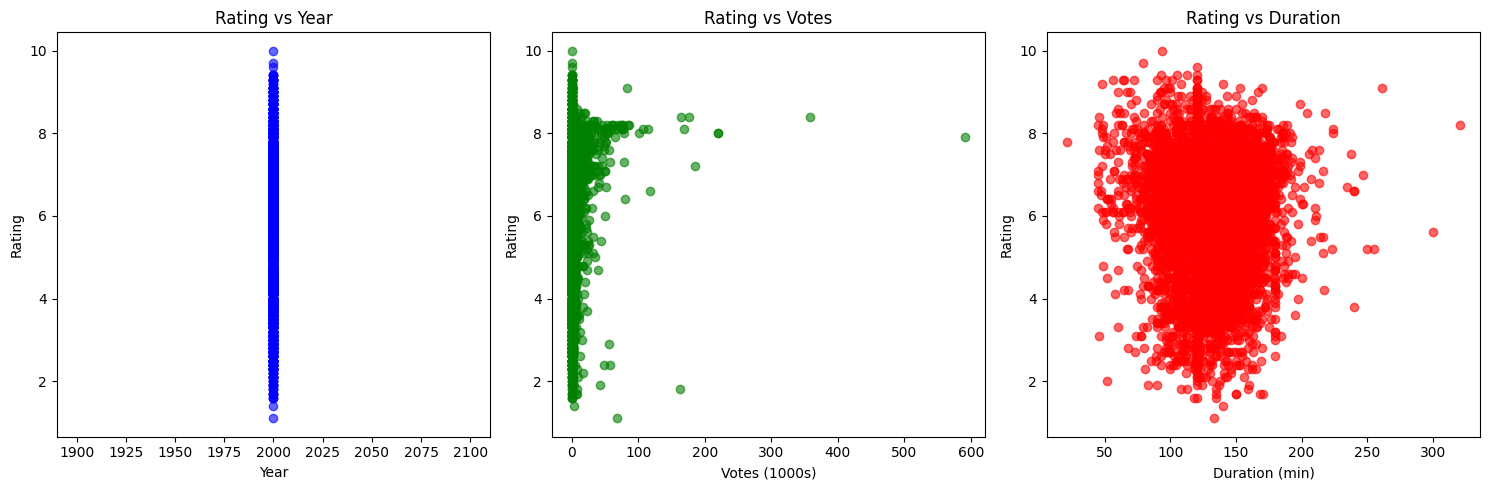

In [ ]:
#EDA GRAPHS 
import matplotlib.pyplot as plt

plt.figure(figsize=(15,5))

# Graph 1: Rating vs Year
plt.subplot(1,3,1)
plt.scatter(df['Year'], df['Rating'], alpha=0.6, color='blue')
plt.xlabel('Year')
plt.ylabel('Rating')
plt.title('Rating vs Year')

# Graph 2: Rating vs Votes
plt.subplot(1,3,2)
plt.scatter(df['Votes']/1000, df['Rating'], alpha=0.6, color='green')
plt.xlabel('Votes (1000s)')
plt.ylabel('Rating')
plt.title('Rating vs Votes')

# Graph 3: Rating vs Duration  
plt.subplot(1,3,3)
plt.scatter(df['Duration'], df['Rating'], alpha=0.6, color='red')
plt.xlabel('Duration (min)')
plt.ylabel('Rating')
plt.title('Rating vs Duration')

plt.tight_layout()
plt.tight_layout()
plt.savefig('movies_plots.png')
plt.show()


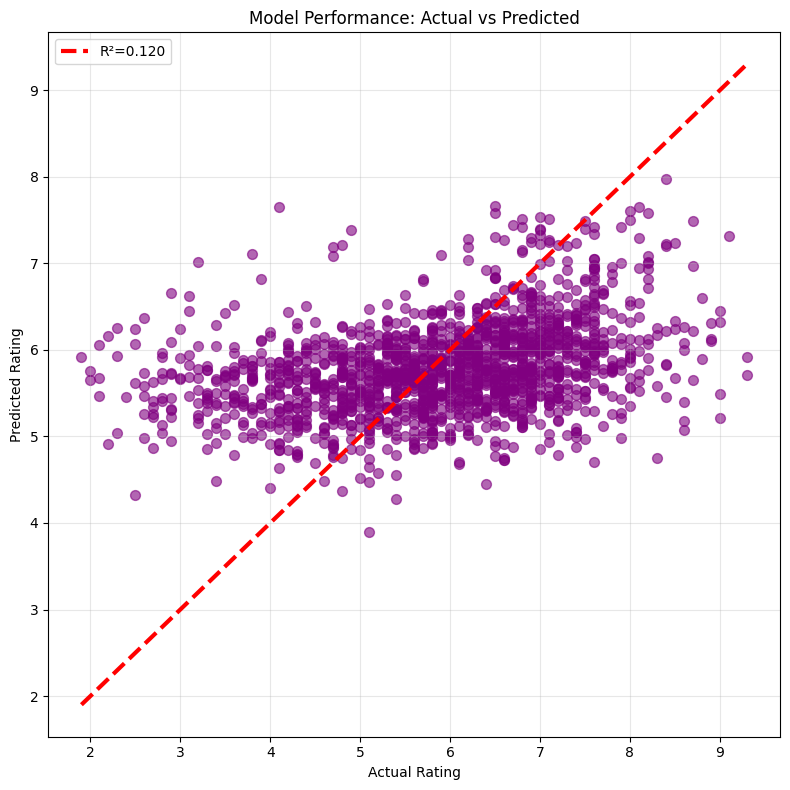

In [18]:
#Actual vs Predicted Scatter Plot
plt.figure(figsize=(8,8))
plt.scatter(y_test, y_pred, alpha=0.6, color='purple', s=50)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=3, label=f'R²={r2:.3f}')
plt.xlabel('Actual Rating')
plt.ylabel('Predicted Rating')
plt.title('Model Performance: Actual vs Predicted')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('model_performance_plots.png')
plt.show()
